In [ ]:
!pip install loralib
!pip install datasets
!pip install transformers[sentencepiece]

     |████████████████████████████████| 290 kB 4.3 MB/s 
     |████████████████████████████████| 243 kB 47.0 MB/s 
     |████████████████████████████████| 59 kB 6.9 MB/s 
     |████████████████████████████████| 1.1 MB 35.8 MB/s 
     |████████████████████████████████| 132 kB 45.2 MB/s 
     |████████████████████████████████| 160 kB 52.4 MB/s 
     |████████████████████████████████| 271 kB 50.5 MB/s 
     |████████████████████████████████| 192 kB 53.2 MB/s 
     |████████████████████████████████| 3.1 MB 4.3 MB/s 
     |████████████████████████████████| 895 kB 36.9 MB/s 
     |████████████████████████████████| 596 kB 44.9 MB/s 
     |████████████████████████████████| 3.3 MB 48.8 MB/s 
     |████████████████████████████████| 1.2 MB 34.6 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
import numpy as np
import loralib as lora
import torchvision.models as models
import torch.nn.functional as F
import torch
from torch import nn
from matplotlib import pyplot as plt
from transformers import AutoModelForSequenceClassification, AutoTokenizer, TrainingArguments, Trainer
from datasets import load_dataset

# Обучение CNN с LORA





In [ ]:
!wget https://download.pytorch.org/models/resnet18-f37072fd.pth

--2021-11-12 09:15:49--  https://download.pytorch.org/models/resnet18-f37072fd.pth
Resolving download.pytorch.org (download.pytorch.org)... 54.230.19.15, 54.230.19.35, 54.230.19.122, ...
Connecting to download.pytorch.org (download.pytorch.org)|54.230.19.15|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 46830571 (45M) [application/x-www-form-urlencoded]
Saving to: ‘resnet18-f37072fd.pth’

resnet18-f37072fd.p 100%[===================>]  44.66M   147MB/s    in 0.3s    

2021-11-12 09:15:50 (147 MB/s) - ‘resnet18-f37072fd.pth’ saved [46830571/46830571]



In [ ]:
def load_lora_model(r=12):
  m = models.resnet18(pretrained=False)
  m.conv1 = lora.Conv2d(3, 64, kernel_size=7, stride=(2, 2), padding=(3, 3), bias=False, r=r)
  m.layer1[0].conv1 = lora.Conv2d(64, 64, kernel_size=3, stride=(1, 1), padding=(1, 1), bias=False, r=r)
  m.layer1[0].conv2 = lora.Conv2d(64, 64, kernel_size=3, stride=(1, 1), padding=(1, 1), bias=False, r=r)
  m.layer1[1].conv1 = lora.Conv2d(64, 64, kernel_size=3, stride=(1, 1), padding=(1, 1), bias=False, r=r)
  m.layer1[1].conv2 = lora.Conv2d(64, 64, kernel_size=3, stride=(1, 1), padding=(1, 1), bias=False, r=r)

  m.layer2[0].conv1 = lora.Conv2d(64, 128, kernel_size=3, stride=(2, 2), padding=(1, 1), bias=False, r=r)
  m.layer2[0].conv2 = lora.Conv2d(128, 128, kernel_size=3, stride=(1, 1), padding=(1, 1), bias=False, r=r)
  m.layer2[0].downsample[0] = lora.Conv2d(64, 128, kernel_size=1, stride=(2, 2), bias=False, r=r)

  m.layer2[1].conv1 = lora.Conv2d(128, 128, kernel_size=3, stride=(1, 1), padding=(1, 1), bias=False, r=r)
  m.layer2[1].conv2 = lora.Conv2d(128, 128, kernel_size=3, stride=(1, 1), padding=(1, 1), bias=False, r=r)


  m.layer3[0].conv1 = lora.Conv2d(128, 256, kernel_size=3, stride=(2, 2), padding=(1, 1), bias=False, r=r)
  m.layer3[0].conv2 = lora.Conv2d(256, 256, kernel_size=3, stride=(1, 1), padding=(1, 1), bias=False, r=r)
  m.layer3[0].downsample[0] = lora.Conv2d(128, 256, kernel_size=1, stride=(2, 2), bias=False, r=r)

  m.layer3[1].conv1 = lora.Conv2d(256, 256, kernel_size=3, stride=(1, 1), padding=(1, 1), bias=False, r=r)
  m.layer3[1].conv2 = lora.Conv2d(256, 256, kernel_size=3, stride=(1, 1), padding=(1, 1), bias=False, r=r)



  m.layer4[0].conv1 = lora.Conv2d(256, 512, kernel_size=3, stride=(2, 2), padding=(1, 1), bias=False, r=r)
  m.layer4[0].conv2 = lora.Conv2d(512, 512, kernel_size=3, stride=(1, 1), padding=(1, 1), bias=False, r=r)
  m.layer4[0].downsample[0] = lora.Conv2d(256, 512, kernel_size=1, stride=(2, 2), bias=False, r=r)

  m.layer4[1].conv1 = lora.Conv2d(512, 512, kernel_size=3, stride=(1, 1), padding=(1, 1), bias=False, r=r)
  m.layer4[1].conv2 = lora.Conv2d(512, 512, kernel_size=3, stride=(1, 1), padding=(1, 1), bias=False, r=r)
  m.load_state_dict(torch.load('resnet18-f37072fd.pth'),strict=False)
  m.fc = lora.Linear(in_features=512, out_features=1000, bias=True, r=r)
  lora.mark_only_lora_as_trainable(m)
  return m

def load_model():
  return models.resnet18(pretrained=True)

In [ ]:
from torchvision import datasets, transforms
train_data = datasets.FashionMNIST(
    root = 'data',
    train = True,                         
    transform = transforms.Compose([
            transforms.Grayscale(num_output_channels=3),
            transforms.Resize([224,224]),
            transforms.ToTensor(),
        ]), 
    download = True,            
)
train_data, _ = torch.utils.data.random_split(train_data, [10000, len(train_data) - 10000])
test_data = datasets.FashionMNIST(
    root = 'data', 
    train = False, 
    transform = transforms.Compose([
            transforms.Grayscale(num_output_channels=3),
            transforms.Resize([224,224]),
            transforms.ToTensor(),
        ])
)
test_data, _ = torch.utils.data.random_split(test_data, [1000, len(test_data) - 1000])

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



In [ ]:
from torch.utils.data import DataLoader
loaders = {
    'train' : torch.utils.data.DataLoader(train_data, 
                                          batch_size=400, 
                                          shuffle=True, 
                                          num_workers=1),
    
    'test'  : torch.utils.data.DataLoader(test_data, 
                                          batch_size=400, 
                                          shuffle=True, 
                                          num_workers=1),
}

In [ ]:
def eval(m, loaders):
    
    m.eval()

    correct = 0
        
    with torch.no_grad():
      for i, (images, labels) in enumerate(tqdm(loaders['test'])):
              
        images = images.cuda()
        labels = labels.cuda()
        output = m(images)               
        correct += (output.argmax(dim=1) == labels).sum().item()

    return correct / len(test_data)
            
                  
        

In [ ]:
from torch.autograd import Variable
from tqdm import tqdm
num_epochs = 10
def train(num_epochs, m, optimizer):
    m.train()
        
    total_step = len(loaders['train'])
    history = []
    for epoch in range(num_epochs):
        epoch_loss = 0
        for i, (images, labels) in enumerate(tqdm(loaders['train'])):
            images = images.cuda()
            labels = labels.cuda()
            output = m(images)               
            loss = loss_func(output, labels)
              
            optimizer.zero_grad()           
            
            loss.backward()     
            optimizer.step()
            epoch_loss += loss.item()
        cur_acc = eval(m, loaders)
        history.append(cur_acc)
        print(f'\n Epoch {epoch + 1} / {num_epochs} ' + 'Val accuracy: {:.2f} Epoch loss: {:.4f}\n'.format(cur_acc, epoch_loss),)
        m.train()
    return history
            
        

In [ ]:
from torch import optim

loss_func = nn.CrossEntropyLoss() 

In [ ]:
def plt_comparison_by_r(epoch_num=15):
  fig, axs = plt.subplots(1, 2, figsize=(12, 6))
  model = load_model()
  optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
  model = model.cuda()
  print('Training standart resnet\n')
  history = train(epoch_num, model, optimizer)
  axs[0].plot(history, label='standart resnet')
  best_acc = []
  
  for r in np.logspace(0, 2.2, 6):
    print(f'Training with r={int(r)}\n')
    model_lora = load_lora_model(r=int(r)).cuda()
    optimizer = torch.optim.Adam(model_lora.parameters(), lr=0.001)
    history = train(epoch_num, model_lora, optimizer)
    best_acc.append(max(history))
    axs[0].plot(history, label='r='+ str(int(r)))
  axs[0].legend()
  axs[1].plot(np.logspace(0, 2.2, 6), best_acc, )


Training standart resnet



100%|██████████| 3/3 [00:03<00:00,  1.04s/it]



 Epoch 1 / 15 Val accuracy: 0.71 Epoch loss: 26.4402



100%|██████████| 3/3 [00:03<00:00,  1.06s/it]



 Epoch 2 / 15 Val accuracy: 0.87 Epoch loss: 6.5778



100%|██████████| 3/3 [00:03<00:00,  1.06s/it]



 Epoch 3 / 15 Val accuracy: 0.87 Epoch loss: 4.4835



100%|██████████| 3/3 [00:03<00:00,  1.07s/it]



 Epoch 4 / 15 Val accuracy: 0.89 Epoch loss: 3.4475



100%|██████████| 3/3 [00:03<00:00,  1.06s/it]



 Epoch 5 / 15 Val accuracy: 0.87 Epoch loss: 2.5469



100%|██████████| 3/3 [00:03<00:00,  1.06s/it]



 Epoch 6 / 15 Val accuracy: 0.90 Epoch loss: 1.9894



100%|██████████| 3/3 [00:03<00:00,  1.07s/it]



 Epoch 7 / 15 Val accuracy: 0.88 Epoch loss: 1.7069



100%|██████████| 3/3 [00:03<00:00,  1.06s/it]



 Epoch 8 / 15 Val accuracy: 0.89 Epoch loss: 1.2445



100%|██████████| 3/3 [00:03<00:00,  1.08s/it]



 Epoch 9 / 15 Val accuracy: 0.88 Epoch loss: 0.8603



100%|██████████| 3/3 [00:03<00:00,  1.08s/it]



 Epoch 10 / 15 Val accuracy: 0.90 Epoch loss: 1.0631



100%|██████████| 3/3 [00:03<00:00,  1.08s/it]



 Epoch 11 / 15 Val accuracy: 0.88 Epoch loss: 1.4059



100%|██████████| 3/3 [00:03<00:00,  1.08s/it]



 Epoch 12 / 15 Val accuracy: 0.90 Epoch loss: 0.8430



100%|██████████| 3/3 [00:03<00:00,  1.05s/it]



 Epoch 13 / 15 Val accuracy: 0.91 Epoch loss: 0.5453



100%|██████████| 3/3 [00:03<00:00,  1.07s/it]



 Epoch 14 / 15 Val accuracy: 0.91 Epoch loss: 0.4722



100%|██████████| 3/3 [00:03<00:00,  1.06s/it]



 Epoch 15 / 15 Val accuracy: 0.90 Epoch loss: 0.4068

Training with r=1



100%|██████████| 3/3 [00:03<00:00,  1.07s/it]



 Epoch 1 / 15 Val accuracy: 0.25 Epoch loss: 151.6796



100%|██████████| 3/3 [00:03<00:00,  1.09s/it]



 Epoch 2 / 15 Val accuracy: 0.56 Epoch loss: 67.1138



100%|██████████| 3/3 [00:03<00:00,  1.08s/it]



 Epoch 3 / 15 Val accuracy: 0.79 Epoch loss: 19.3293



100%|██████████| 3/3 [00:03<00:00,  1.08s/it]



 Epoch 4 / 15 Val accuracy: 0.84 Epoch loss: 12.0039



100%|██████████| 3/3 [00:03<00:00,  1.10s/it]



 Epoch 5 / 15 Val accuracy: 0.86 Epoch loss: 9.4804



100%|██████████| 3/3 [00:03<00:00,  1.08s/it]



 Epoch 6 / 15 Val accuracy: 0.86 Epoch loss: 7.9497



100%|██████████| 3/3 [00:03<00:00,  1.08s/it]



 Epoch 7 / 15 Val accuracy: 0.87 Epoch loss: 6.7621



100%|██████████| 3/3 [00:03<00:00,  1.07s/it]



 Epoch 8 / 15 Val accuracy: 0.88 Epoch loss: 5.8570



100%|██████████| 3/3 [00:03<00:00,  1.09s/it]



 Epoch 9 / 15 Val accuracy: 0.88 Epoch loss: 5.0785



100%|██████████| 3/3 [00:03<00:00,  1.09s/it]



 Epoch 10 / 15 Val accuracy: 0.87 Epoch loss: 4.3756



100%|██████████| 3/3 [00:03<00:00,  1.10s/it]



 Epoch 11 / 15 Val accuracy: 0.89 Epoch loss: 3.9026



100%|██████████| 3/3 [00:03<00:00,  1.10s/it]



 Epoch 12 / 15 Val accuracy: 0.88 Epoch loss: 3.2957



100%|██████████| 3/3 [00:03<00:00,  1.10s/it]



 Epoch 13 / 15 Val accuracy: 0.88 Epoch loss: 2.8480



100%|██████████| 3/3 [00:03<00:00,  1.08s/it]



 Epoch 14 / 15 Val accuracy: 0.89 Epoch loss: 2.4965



100%|██████████| 3/3 [00:03<00:00,  1.10s/it]



 Epoch 15 / 15 Val accuracy: 0.88 Epoch loss: 2.1068

Training with r=2



100%|██████████| 3/3 [00:03<00:00,  1.12s/it]



 Epoch 1 / 15 Val accuracy: 0.16 Epoch loss: 157.9406



100%|██████████| 3/3 [00:03<00:00,  1.11s/it]



 Epoch 2 / 15 Val accuracy: 0.70 Epoch loss: 66.2204



100%|██████████| 3/3 [00:03<00:00,  1.10s/it]



 Epoch 3 / 15 Val accuracy: 0.79 Epoch loss: 18.1387



100%|██████████| 3/3 [00:03<00:00,  1.10s/it]



 Epoch 4 / 15 Val accuracy: 0.84 Epoch loss: 11.7460



100%|██████████| 3/3 [00:03<00:00,  1.09s/it]



 Epoch 5 / 15 Val accuracy: 0.87 Epoch loss: 9.2308



100%|██████████| 3/3 [00:03<00:00,  1.09s/it]



 Epoch 6 / 15 Val accuracy: 0.88 Epoch loss: 7.8052



100%|██████████| 3/3 [00:03<00:00,  1.10s/it]



 Epoch 7 / 15 Val accuracy: 0.89 Epoch loss: 6.6763



100%|██████████| 3/3 [00:03<00:00,  1.11s/it]



 Epoch 8 / 15 Val accuracy: 0.87 Epoch loss: 5.8168



100%|██████████| 3/3 [00:03<00:00,  1.11s/it]



 Epoch 9 / 15 Val accuracy: 0.87 Epoch loss: 5.1001



100%|██████████| 3/3 [00:03<00:00,  1.11s/it]



 Epoch 10 / 15 Val accuracy: 0.89 Epoch loss: 4.4376



100%|██████████| 3/3 [00:03<00:00,  1.11s/it]



 Epoch 11 / 15 Val accuracy: 0.89 Epoch loss: 3.8771



100%|██████████| 3/3 [00:03<00:00,  1.11s/it]



 Epoch 12 / 15 Val accuracy: 0.88 Epoch loss: 3.2815



100%|██████████| 3/3 [00:03<00:00,  1.11s/it]



 Epoch 13 / 15 Val accuracy: 0.89 Epoch loss: 2.8090



100%|██████████| 3/3 [00:03<00:00,  1.12s/it]



 Epoch 14 / 15 Val accuracy: 0.91 Epoch loss: 2.3060



100%|██████████| 3/3 [00:03<00:00,  1.11s/it]



 Epoch 15 / 15 Val accuracy: 0.90 Epoch loss: 1.9318

Training with r=7



100%|██████████| 3/3 [00:03<00:00,  1.09s/it]



 Epoch 1 / 15 Val accuracy: 0.25 Epoch loss: 157.4819



100%|██████████| 3/3 [00:03<00:00,  1.13s/it]



 Epoch 2 / 15 Val accuracy: 0.64 Epoch loss: 67.4409



100%|██████████| 3/3 [00:03<00:00,  1.12s/it]



 Epoch 3 / 15 Val accuracy: 0.79 Epoch loss: 18.4909



100%|██████████| 3/3 [00:03<00:00,  1.12s/it]



 Epoch 4 / 15 Val accuracy: 0.85 Epoch loss: 11.2995



100%|██████████| 3/3 [00:03<00:00,  1.10s/it]



 Epoch 5 / 15 Val accuracy: 0.86 Epoch loss: 9.1066



100%|██████████| 3/3 [00:03<00:00,  1.11s/it]



 Epoch 6 / 15 Val accuracy: 0.87 Epoch loss: 7.6194



100%|██████████| 3/3 [00:03<00:00,  1.10s/it]



 Epoch 7 / 15 Val accuracy: 0.89 Epoch loss: 6.4937



100%|██████████| 3/3 [00:03<00:00,  1.10s/it]



 Epoch 8 / 15 Val accuracy: 0.87 Epoch loss: 5.7003



100%|██████████| 3/3 [00:03<00:00,  1.10s/it]



 Epoch 9 / 15 Val accuracy: 0.88 Epoch loss: 4.9120



100%|██████████| 3/3 [00:03<00:00,  1.09s/it]



 Epoch 10 / 15 Val accuracy: 0.88 Epoch loss: 4.2380



100%|██████████| 3/3 [00:03<00:00,  1.11s/it]



 Epoch 11 / 15 Val accuracy: 0.88 Epoch loss: 3.6437



100%|██████████| 3/3 [00:03<00:00,  1.11s/it]



 Epoch 12 / 15 Val accuracy: 0.90 Epoch loss: 3.0838



100%|██████████| 3/3 [00:03<00:00,  1.10s/it]



 Epoch 13 / 15 Val accuracy: 0.90 Epoch loss: 2.5973



100%|██████████| 3/3 [00:03<00:00,  1.11s/it]



 Epoch 14 / 15 Val accuracy: 0.90 Epoch loss: 2.1111



100%|██████████| 3/3 [00:03<00:00,  1.10s/it]



 Epoch 15 / 15 Val accuracy: 0.89 Epoch loss: 1.6950

Training with r=20



100%|██████████| 3/3 [00:03<00:00,  1.11s/it]



 Epoch 1 / 15 Val accuracy: 0.17 Epoch loss: 146.7851



100%|██████████| 3/3 [00:03<00:00,  1.12s/it]



 Epoch 2 / 15 Val accuracy: 0.66 Epoch loss: 64.3179



100%|██████████| 3/3 [00:03<00:00,  1.10s/it]



 Epoch 3 / 15 Val accuracy: 0.78 Epoch loss: 19.0056



100%|██████████| 3/3 [00:03<00:00,  1.11s/it]



 Epoch 4 / 15 Val accuracy: 0.84 Epoch loss: 12.0614



100%|██████████| 3/3 [00:03<00:00,  1.11s/it]



 Epoch 5 / 15 Val accuracy: 0.86 Epoch loss: 9.4602



100%|██████████| 3/3 [00:03<00:00,  1.12s/it]



 Epoch 6 / 15 Val accuracy: 0.87 Epoch loss: 7.8104



100%|██████████| 3/3 [00:03<00:00,  1.10s/it]



 Epoch 7 / 15 Val accuracy: 0.88 Epoch loss: 6.5289



100%|██████████| 3/3 [00:03<00:00,  1.10s/it]



 Epoch 8 / 15 Val accuracy: 0.89 Epoch loss: 5.5997



100%|██████████| 3/3 [00:03<00:00,  1.10s/it]



 Epoch 9 / 15 Val accuracy: 0.89 Epoch loss: 4.8256



100%|██████████| 3/3 [00:03<00:00,  1.09s/it]



 Epoch 10 / 15 Val accuracy: 0.89 Epoch loss: 4.1211



100%|██████████| 3/3 [00:03<00:00,  1.10s/it]



 Epoch 11 / 15 Val accuracy: 0.90 Epoch loss: 3.4437



100%|██████████| 3/3 [00:03<00:00,  1.09s/it]



 Epoch 12 / 15 Val accuracy: 0.90 Epoch loss: 2.9232



100%|██████████| 3/3 [00:03<00:00,  1.08s/it]



 Epoch 13 / 15 Val accuracy: 0.90 Epoch loss: 2.3689



100%|██████████| 3/3 [00:03<00:00,  1.08s/it]



 Epoch 14 / 15 Val accuracy: 0.90 Epoch loss: 1.9908



100%|██████████| 3/3 [00:03<00:00,  1.09s/it]



 Epoch 15 / 15 Val accuracy: 0.91 Epoch loss: 1.7095

Training with r=57



100%|██████████| 3/3 [00:03<00:00,  1.08s/it]



 Epoch 1 / 15 Val accuracy: 0.31 Epoch loss: 152.4706



100%|██████████| 3/3 [00:03<00:00,  1.10s/it]



 Epoch 2 / 15 Val accuracy: 0.65 Epoch loss: 63.9216



100%|██████████| 3/3 [00:03<00:00,  1.08s/it]



 Epoch 3 / 15 Val accuracy: 0.80 Epoch loss: 17.8285



100%|██████████| 3/3 [00:03<00:00,  1.08s/it]



 Epoch 4 / 15 Val accuracy: 0.83 Epoch loss: 11.6016



100%|██████████| 3/3 [00:03<00:00,  1.09s/it]



 Epoch 5 / 15 Val accuracy: 0.85 Epoch loss: 9.1912



100%|██████████| 3/3 [00:03<00:00,  1.07s/it]



 Epoch 6 / 15 Val accuracy: 0.87 Epoch loss: 7.6672



100%|██████████| 3/3 [00:03<00:00,  1.08s/it]



 Epoch 7 / 15 Val accuracy: 0.88 Epoch loss: 6.5753



100%|██████████| 3/3 [00:03<00:00,  1.15s/it]



 Epoch 8 / 15 Val accuracy: 0.89 Epoch loss: 5.7177



100%|██████████| 3/3 [00:03<00:00,  1.10s/it]



 Epoch 9 / 15 Val accuracy: 0.88 Epoch loss: 4.8728



100%|██████████| 3/3 [00:03<00:00,  1.08s/it]



 Epoch 10 / 15 Val accuracy: 0.88 Epoch loss: 4.2338



100%|██████████| 3/3 [00:03<00:00,  1.10s/it]



 Epoch 11 / 15 Val accuracy: 0.89 Epoch loss: 3.5927



100%|██████████| 3/3 [00:03<00:00,  1.09s/it]



 Epoch 12 / 15 Val accuracy: 0.87 Epoch loss: 2.9737



100%|██████████| 3/3 [00:03<00:00,  1.10s/it]



 Epoch 13 / 15 Val accuracy: 0.89 Epoch loss: 2.5201



100%|██████████| 3/3 [00:03<00:00,  1.11s/it]



 Epoch 14 / 15 Val accuracy: 0.89 Epoch loss: 2.0036



100%|██████████| 3/3 [00:03<00:00,  1.10s/it]



 Epoch 15 / 15 Val accuracy: 0.88 Epoch loss: 1.6867

Training with r=158



100%|██████████| 3/3 [00:03<00:00,  1.10s/it]



 Epoch 1 / 15 Val accuracy: 0.32 Epoch loss: 152.0927



100%|██████████| 3/3 [00:03<00:00,  1.10s/it]



 Epoch 2 / 15 Val accuracy: 0.68 Epoch loss: 62.0377



100%|██████████| 3/3 [00:03<00:00,  1.09s/it]



 Epoch 3 / 15 Val accuracy: 0.81 Epoch loss: 17.4278



100%|██████████| 3/3 [00:03<00:00,  1.10s/it]



 Epoch 4 / 15 Val accuracy: 0.85 Epoch loss: 11.4663



100%|██████████| 3/3 [00:03<00:00,  1.12s/it]



 Epoch 5 / 15 Val accuracy: 0.86 Epoch loss: 9.1299



100%|██████████| 3/3 [00:03<00:00,  1.12s/it]



 Epoch 6 / 15 Val accuracy: 0.88 Epoch loss: 7.6106



100%|██████████| 3/3 [00:03<00:00,  1.10s/it]



 Epoch 7 / 15 Val accuracy: 0.88 Epoch loss: 6.3964



100%|██████████| 3/3 [00:03<00:00,  1.09s/it]



 Epoch 8 / 15 Val accuracy: 0.90 Epoch loss: 5.5684



100%|██████████| 3/3 [00:03<00:00,  1.10s/it]



 Epoch 9 / 15 Val accuracy: 0.89 Epoch loss: 4.7853



100%|██████████| 3/3 [00:03<00:00,  1.13s/it]



 Epoch 10 / 15 Val accuracy: 0.89 Epoch loss: 4.1015



100%|██████████| 3/3 [00:03<00:00,  1.11s/it]



 Epoch 11 / 15 Val accuracy: 0.88 Epoch loss: 3.4636



100%|██████████| 3/3 [00:03<00:00,  1.11s/it]



 Epoch 12 / 15 Val accuracy: 0.88 Epoch loss: 2.8772



100%|██████████| 3/3 [00:03<00:00,  1.10s/it]



 Epoch 13 / 15 Val accuracy: 0.90 Epoch loss: 2.5110



100%|██████████| 3/3 [00:03<00:00,  1.09s/it]



 Epoch 14 / 15 Val accuracy: 0.89 Epoch loss: 2.0279



100%|██████████| 3/3 [00:03<00:00,  1.10s/it]



 Epoch 15 / 15 Val accuracy: 0.90 Epoch loss: 1.6408



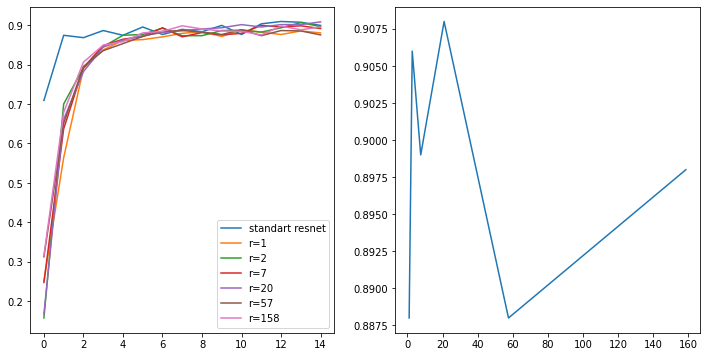

In [ ]:
plt_comparison_by_r(15)

# Обучение BERT с LORA


In [ ]:
import numpy as np
import loralib as lora
import torchvision.models as models
import torch.nn.functional as F
import torch
from torch import nn
from matplotlib import pyplot as plt
from transformers import AutoModelForSequenceClassification, AutoTokenizer, TrainingArguments, Trainer
from datasets import load_dataset

In [ ]:
def linear_to_lora_linear(linear, r=6):
    bias = linear.bias is not None
    lora_layer = lora.Linear(
        in_features=linear.in_features,
        out_features=linear.out_features,
        bias=bias,
        r=r,
    )
    
    lora_layer.weight = nn.Parameter(linear.weight.detach())
    
    if bias:
        lora_layer.bias = nn.Parameter(linear.bias.detach())
    
    return lora_layer


def to_lora(model, r=6):
    if isinstance(model, nn.ModuleList) or isinstance(model, nn.Sequential):
        for i, elem in enumerate(model):
            if isinstance(model[i], nn.Linear):
                model[i] = linear_to_lora_linear(model[i], r)
            else:
                if isinstance(model, nn.Module):
                    to_lora(model[i])
        
    else:
        for key in dir(model):
            attr = getattr(model, key)
            if attr is model:
              continue
            if isinstance(attr, nn.Linear):
                setattr(model, key, linear_to_lora_linear(attr, r))
                continue
            if not isinstance(attr, nn.Module):
                continue
            
            to_lora(attr)


In [ ]:
from datasets import DatasetDict
dataset = load_dataset('tweet_eval', 'irony')

model_name = 'bert-base-cased'
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)
model = model.cuda()
to_lora(model)
tokenizer = AutoTokenizer.from_pretrained(model_name)
datasets = dataset.map(lambda d: tokenizer(d['text'], truncation=True, padding=True), batched=True)

Reusing dataset tweet_eval (/root/.cache/huggingface/datasets/tweet_eval/irony/1.1.0/12aee5282b8784f3e95459466db4cdf45c6bf49719c25cdb0743d71ed0410343)


  0%|          | 0/3 [00:00<?, ?it/s]

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at b

In [ ]:
args = TrainingArguments(
    'lora_bert',
    evaluation_strategy = 'epoch',
    save_strategy = 'no',
    load_best_model_at_end=False,
    weight_decay=0,
    report_to='none',
    learning_rate=5e-3,
    metric_for_best_model='f1',
    gradient_accumulation_steps=1,
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
)

from datasets import load_metric
metric = load_metric('f1')

def compute_metrics(pred):
    logits, labels = pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels, average='micro')

In [ ]:
trainer = Trainer(
    model,
    args,
    train_dataset=datasets['train'],
    eval_dataset=datasets['validation'],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)
trainer.train()

The following columns in the training set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text.
***** Running training *****
  Num examples = 2862
  Num Epochs = 3
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 537


Epoch,Training Loss,Validation Loss,F1
1,No log,1.526610,0.477487
2,No log,0.699333,0.522513
3,0.858300,0.721700,0.477487


The following columns in the evaluation set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text.
***** Running Evaluation *****
  Num examples = 955
  Batch size = 16
The following columns in the evaluation set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text.
***** Running Evaluation *****
  Num examples = 955
  Batch size = 16
The following columns in the evaluation set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text.
***** Running Evaluation *****
  Num examples = 955
  Batch size = 16


Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=537, training_loss=0.8502990608996741, metrics={'train_runtime': 1096.0028, 'train_samples_per_second': 7.834, 'train_steps_per_second': 0.49, 'total_flos': 1388377756045944.0, 'train_loss': 0.8502990608996741, 'epoch': 3.0})

In [ ]:
model_bert = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)
model_bert = model.cuda()
trainer = Trainer(
    model_bert,
    args,
    train_dataset=datasets['train'],
    eval_dataset=datasets['validation'],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)
trainer.train()

loading configuration file https://huggingface.co/bert-base-cased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/a803e0468a8fe090683bdc453f4fac622804f49de86d7cecaee92365d4a0f829.a64a22196690e0e82ead56f388a3ef3a50de93335926ccfa20610217db589307
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.12.3",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 28996
}

loading weights file https://huggingface.co/bert-base-cased/resolve/main/pytorch_model.bin from cache at /

Epoch,Training Loss,Validation Loss,F1
1,No log,0.727390,0.477487
2,No log,0.704051,0.477487
3,0.808200,0.733299,0.477487


The following columns in the evaluation set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text.
***** Running Evaluation *****
  Num examples = 955
  Batch size = 16
The following columns in the evaluation set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text.
***** Running Evaluation *****
  Num examples = 955
  Batch size = 16
The following columns in the evaluation set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text.
***** Running Evaluation *****
  Num examples = 955
  Batch size = 16


Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=537, training_loss=0.8046284538851548, metrics={'train_runtime': 1095.6787, 'train_samples_per_second': 7.836, 'train_steps_per_second': 0.49, 'total_flos': 1388377756045944.0, 'train_loss': 0.8046284538851548, 'epoch': 3.0})